In [1]:
# !wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/testing_data.pkl
# !wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/training_data.pkl

In [2]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Piece-wise Constant Transmittance Equation
<div>
<img src='../assets/transmittance.png'>
</div>

Here, $\delta_k$ is constant for as the ray are uniformly breakdown.

$\sigma_k$ is constant for the piece-wise segment.

$\alpha_k = 1 - exp(-\sigma_k \delta_k)$

$exp(-\sigma_k \delta_k) = 1 - \alpha_k$

$T_n = exp(\sum_{k=1}^{n-1} -\sigma_k \delta_k) = \prod_{k=1}^{n-1} exp( -\sigma_k \delta_k) = \prod_{k=1}^{n-1} (1 - \alpha_k)$

In [3]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(1 - alphas, dim=1)
    ones = torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device) 
    return torch.cat((ones, accumulated_transmittance[:, :-1]), dim=-1) # Making first element of each series as 1 and leaving out the last element of cumprod

# NeRF Architecture
<div>
<img src='../assets/NeRFModel.png'>
</div>

In [4]:
class NeRFModel(nn.Module):
    def __init__(self, embedding_dim_pos=6, embedding_dim_direction=4, hidden_dim=256):
        super(NeRFModel, self).__init__()

        input_dim_block1 = embedding_dim_pos * 6 + 3
        layer_activation = nn.ReLU()

        self.block1 = nn.Sequential(nn.Linear(input_dim_block1, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation)

        # density estimation
        input_dim_block2 = embedding_dim_pos * 6 + hidden_dim + 3

        self.block2 = nn.Sequential(nn.Linear(input_dim_block2, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim),
                                    layer_activation,
                                    nn.Linear(hidden_dim, hidden_dim + 1))

        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos) # emb_x: [batch_size, embedding_dim_pos * 6 + 3]
        emb_d = self.positional_encoding(d, self.embedding_dim_direction) # emb_d: [batch_size, embedding_dim_direction * 6 + 3]
        h = self.block1(emb_x) # h: [batch_size, hidden_dim]

        tmp = self.block2(torch.cat((h, emb_x), dim=1)) # tmp: [batch_size, hidden_dim + 1]

        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1]) # h: [batch_size, hidden_dim], sigma: [batch_size]

        h = self.block3(torch.cat((h, emb_d), dim=1)) # h: [batch_size, hidden_dim // 2]

        c = self.block4(h) # c: [batch_size, 3]
        return c, sigma

# Ray Equation
$$r = o + td$$

<div>
<img src='../assets/renderingEquation.png'>
</div>

In [5]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):

    # ray_origins : torch.Size([8192, 3]) || ray_directions : torch.Size([8192, 3])

    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins).to(device) # [32]

    # Compute the 3D points along each ray
    t = t.unsqueeze(dim=0).unsqueeze(2) # [1, 32, 1]
    r = ray_origins.unsqueeze(1) + t * ray_directions.unsqueeze(1)  # [batch_size, nb_bins, 3]

    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1) # [batch_size, nb_bins, 3]


    colors, sigma = nerf_model(r.reshape(-1, 3), ray_directions.reshape(-1, 3)) # x : [batch_size * nb_bins, 3], ray_directions : [batch_size * nb_bins, 3]  
    colors = colors.reshape(r.shape)  # [batch_size, nb_bins, 3]
    sigma = sigma.reshape(r.shape[:-1])  # [batch_size, nb_bins]

    alpha = 1 - torch.exp(-sigma*(hf-hn)/nb_bins)  # [batch_size, nb_bins]

    weights = compute_accumulated_transmittance(alpha) * alpha
    
    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights.unsqueeze(2) * colors).sum(dim=1)
    
    weight_sum = weights.sum(-1)  # Regularization for white background
    
    return c + 1 - weight_sum.unsqueeze(-1)

In [9]:
def train(nerf_model, optimizer, scheduler, data_loader, testing_dataset, device='cpu', hn=0, hf=1, nb_epochs=int(1e5),
          nb_bins=192, H=400, W=400):
    training_loss = []
    test_images = []
    
    for epoch in tqdm(range(nb_epochs)):
        # Training loop
        nerf_model.train()
        for batch in data_loader:
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)
            
            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins)
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            print(f"Loss: {loss.item():.4f}")
        
        scheduler.step()
        img_index = 0
        img = test(nerf_model, testing_dataset, img_index, hn, hf, nb_bins, device, H=400, W=400)
        test_images.append(img)
        plt.figure()
        plt.imshow(img)
        plt.title(f'Epoch {epoch}')
        plt.show()
        plt.close()

    return training_loss, test_images


def test(nerf_model, testing_dataset, img_index, hn, hf, nb_bins, device, H=400, W=400):
        # Testing/Validation loop
        nerf_model.eval()
        with torch.no_grad():  # Changed from torch.inference_mode
            chunk_size = 10
            ray_origins = testing_dataset[img_index * H * W: (img_index + 1) * H * W, :3]
            ray_directions = testing_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

            data = []
            for i in range(int(np.ceil(H * W / (W * chunk_size)))):  # Corrected iteration calculation
                # Get chunk of rays
                start_idx = W * chunk_size * i
                end_idx = min(W * chunk_size * (i + 1), H * W)  # Added min to prevent index out of bounds
                
                ray_origins_ = ray_origins[start_idx:end_idx].to(device)
                ray_directions_ = ray_directions[start_idx:end_idx].to(device)

                regenerated_px_values = render_rays(nerf_model, ray_origins_, ray_directions_, 
                                                 hn=hn, hf=hf, nb_bins=nb_bins)
                data.append(regenerated_px_values.cpu())  # Move to CPU before appending

            img = torch.cat(data).numpy().reshape(H, W, 3)
            return img


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 2348.9624
Loss: 5230.0684
Loss: 2527.7563
Loss: 2172.3369
Loss: 2187.8562
Loss: 2253.1804
Loss: 2259.6116
Loss: 2207.5938
Loss: 2218.8579
Loss: 2123.9829
Loss: 2129.6770
Loss: 2062.4971
Loss: 2056.9390
Loss: 2037.2247
Loss: 1906.7056
Loss: 1811.5269
Loss: 1713.1152
Loss: 1704.9578
Loss: 1659.2716
Loss: 1514.9717
Loss: 1355.3904
Loss: 1187.6462
Loss: 1221.0547
Loss: 1865.1299
Loss: 1297.4236
Loss: 1006.9148
Loss: 1314.4155
Loss: 1155.2549
Loss: 992.6000
Loss: 984.0088
Loss: 1087.2068
Loss: 989.5104
Loss: 958.5424
Loss: 912.6957
Loss: 848.1253
Loss: 830.0486
Loss: 886.2707
Loss: 864.0704
Loss: 861.0602
Loss: 825.0583
Loss: 760.8452
Loss: 783.2224
Loss: 758.9492
Loss: 746.5060
Loss: 730.2211
Loss: 732.9091
Loss: 710.6449
Loss: 696.5305
Loss: 699.9004
Loss: 678.3461
Loss: 653.5317
Loss: 655.3856
Loss: 666.9973
Loss: 609.3868
Loss: 631.7789
Loss: 602.2650
Loss: 616.7996
Loss: 574.2474
Loss: 596.6310
Loss: 590.8382
Loss: 556.7491
Loss: 541.5818
Loss: 574.6454
Loss: 529.4581
Loss: 537.0

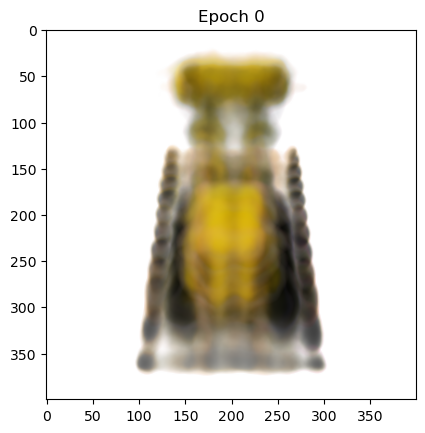

 10%|█         | 1/10 [01:12<10:51, 72.34s/it]

Loss: 376.3351
Loss: 322.0030
Loss: 333.5981
Loss: 331.7154
Loss: 335.6784
Loss: 340.6707
Loss: 319.9127
Loss: 331.1628
Loss: 309.6971
Loss: 324.2959
Loss: 313.9662
Loss: 336.1588
Loss: 303.2659
Loss: 319.9335
Loss: 319.4543
Loss: 304.1045
Loss: 303.5858
Loss: 293.0293
Loss: 296.0451
Loss: 299.0308
Loss: 309.5995
Loss: 306.3531
Loss: 297.0989
Loss: 294.2158
Loss: 290.5539
Loss: 285.3203
Loss: 306.1880
Loss: 303.8865
Loss: 292.7127
Loss: 288.4979
Loss: 293.1317
Loss: 288.9390
Loss: 295.2382
Loss: 281.8083
Loss: 286.4188
Loss: 282.7931
Loss: 289.5229
Loss: 286.0904
Loss: 287.7151
Loss: 286.3958
Loss: 267.1489
Loss: 303.6729
Loss: 289.4037
Loss: 274.0697
Loss: 274.4337
Loss: 277.3968
Loss: 260.7226
Loss: 272.4380
Loss: 274.5256
Loss: 282.3522
Loss: 299.7698
Loss: 274.6560
Loss: 283.1043
Loss: 298.5655
Loss: 282.9318
Loss: 277.1732
Loss: 285.7002
Loss: 276.1137
Loss: 271.9845
Loss: 258.8994
Loss: 281.9996
Loss: 281.0279
Loss: 256.1033
Loss: 270.3080
Loss: 244.8412
Loss: 277.5660
Loss: 248.

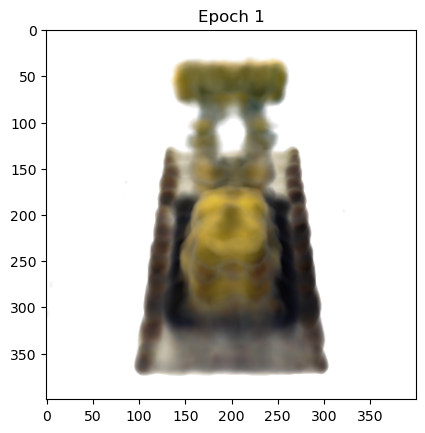

 20%|██        | 2/10 [02:24<09:37, 72.19s/it]

Loss: 270.6068
Loss: 246.0056
Loss: 250.6661
Loss: 253.5793
Loss: 255.3376
Loss: 245.3202
Loss: 235.5870
Loss: 254.0202
Loss: 239.1125
Loss: 252.0481
Loss: 222.5127
Loss: 242.3485
Loss: 245.8723
Loss: 222.8325
Loss: 249.8601
Loss: 220.7635
Loss: 246.0906
Loss: 238.3844
Loss: 231.9970
Loss: 246.9839
Loss: 217.5106
Loss: 236.4865
Loss: 232.6982
Loss: 241.5926
Loss: 217.4394
Loss: 233.3132
Loss: 221.8342
Loss: 228.7908
Loss: 237.9480
Loss: 218.4474
Loss: 240.5201
Loss: 224.9822
Loss: 225.1071
Loss: 228.0725
Loss: 220.6314
Loss: 220.8391
Loss: 226.5948
Loss: 225.4442
Loss: 223.6131
Loss: 227.6711
Loss: 219.8877
Loss: 236.8407
Loss: 218.2932
Loss: 231.5282
Loss: 246.1693
Loss: 211.4586
Loss: 236.0948
Loss: 214.0409
Loss: 233.3560
Loss: 216.1056
Loss: 228.9892
Loss: 209.5576
Loss: 228.6308
Loss: 229.5257
Loss: 221.2281
Loss: 232.8939
Loss: 235.2607
Loss: 230.5791
Loss: 221.9328
Loss: 235.3882
Loss: 220.5075
Loss: 233.0112
Loss: 235.5728
Loss: 222.3378
Loss: 231.1324
Loss: 231.6108
Loss: 231.

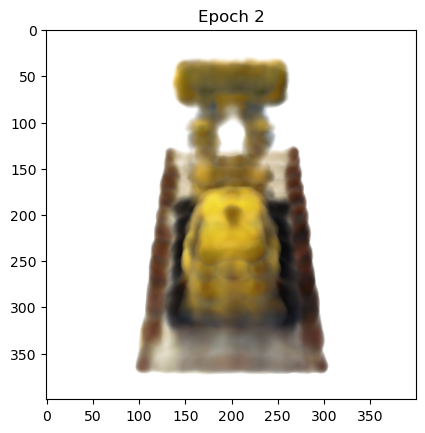

 30%|███       | 3/10 [03:37<08:28, 72.57s/it]

Loss: 224.0339
Loss: 229.6061
Loss: 211.0453
Loss: 209.1320
Loss: 204.8926
Loss: 201.3950
Loss: 203.3231
Loss: 209.5819
Loss: 224.5306
Loss: 226.1934
Loss: 218.4695
Loss: 207.6487
Loss: 217.5825
Loss: 211.1581
Loss: 215.1669
Loss: 219.6134
Loss: 208.9736
Loss: 221.5153
Loss: 205.9391
Loss: 204.5265
Loss: 224.8534
Loss: 223.8575
Loss: 218.3389
Loss: 205.4819
Loss: 213.4832
Loss: 216.6653
Loss: 212.2235
Loss: 212.1414
Loss: 231.1310
Loss: 218.2773
Loss: 202.2711
Loss: 221.8447
Loss: 235.0436
Loss: 206.7698
Loss: 235.5478
Loss: 213.1698
Loss: 228.1342
Loss: 211.0519
Loss: 232.8824
Loss: 208.2383
Loss: 232.9546
Loss: 229.4412
Loss: 224.0030
Loss: 216.5444
Loss: 228.9348
Loss: 198.8666
Loss: 215.0080
Loss: 203.0046
Loss: 216.0321
Loss: 214.2629
Loss: 208.7324
Loss: 209.4854
Loss: 218.1138
Loss: 208.3499
Loss: 224.5406
Loss: 212.6076
Loss: 210.1064
Loss: 218.4731
Loss: 206.2751
Loss: 205.7374
Loss: 197.5655
Loss: 205.8190
Loss: 207.7950
Loss: 197.1361
Loss: 215.2209
Loss: 202.2482
Loss: 221.

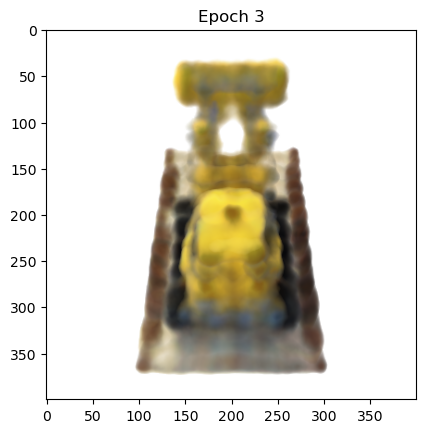

 40%|████      | 4/10 [04:47<07:10, 71.70s/it]

Loss: 206.3262
Loss: 196.5602
Loss: 200.3750
Loss: 206.1241
Loss: 208.1965
Loss: 187.7982
Loss: 196.8957
Loss: 199.7222
Loss: 182.7384
Loss: 190.4647
Loss: 191.8110
Loss: 194.2682
Loss: 196.4403
Loss: 204.8910
Loss: 199.7744
Loss: 193.6071
Loss: 180.1835
Loss: 201.7279
Loss: 192.6031
Loss: 179.3020
Loss: 210.0792
Loss: 209.6354
Loss: 204.1576
Loss: 182.6917
Loss: 192.8881
Loss: 195.9210
Loss: 190.5883
Loss: 194.6001
Loss: 190.6125
Loss: 186.1928
Loss: 191.3759
Loss: 204.1718
Loss: 190.6037
Loss: 190.1504
Loss: 197.1144
Loss: 185.4802
Loss: 207.3818
Loss: 200.9957
Loss: 188.2464
Loss: 210.0352
Loss: 208.0671
Loss: 188.5856
Loss: 184.4627
Loss: 201.8561
Loss: 200.1874
Loss: 184.9198
Loss: 188.6264
Loss: 196.0761
Loss: 196.4433
Loss: 188.6808
Loss: 193.2103
Loss: 196.7674
Loss: 187.2209
Loss: 190.5120
Loss: 196.6006
Loss: 194.1566
Loss: 206.9044
Loss: 196.4672
Loss: 185.1758
Loss: 182.8257
Loss: 198.8483
Loss: 196.5057
Loss: 199.5681
Loss: 194.1594
Loss: 198.4456
Loss: 197.7971
Loss: 196.

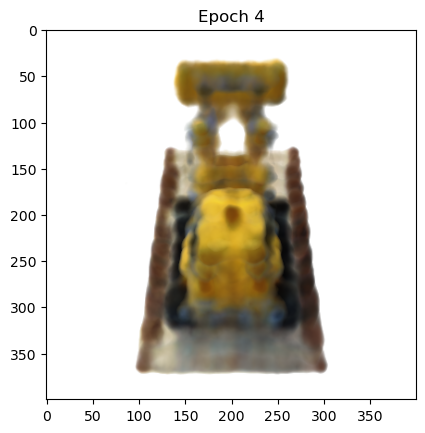

 50%|█████     | 5/10 [05:55<05:51, 70.32s/it]

Loss: 211.8388
Loss: 192.4975
Loss: 208.3673
Loss: 204.3070
Loss: 193.5482
Loss: 191.6894
Loss: 198.9060
Loss: 184.9615
Loss: 203.2264
Loss: 193.6403
Loss: 192.0118
Loss: 180.5101
Loss: 186.0678
Loss: 184.6373
Loss: 184.4313
Loss: 194.5795
Loss: 193.3580
Loss: 184.2004
Loss: 186.6455
Loss: 181.9524
Loss: 186.1817
Loss: 193.3545
Loss: 186.2769
Loss: 179.1388
Loss: 185.1606
Loss: 190.6763
Loss: 190.2431
Loss: 181.5470
Loss: 196.4372
Loss: 185.1656
Loss: 192.4191
Loss: 198.8814
Loss: 202.3803
Loss: 202.0700
Loss: 184.1864
Loss: 182.3280
Loss: 197.8484
Loss: 194.3754
Loss: 178.8482
Loss: 192.2210
Loss: 201.6832
Loss: 187.3594
Loss: 172.6888
Loss: 185.4695
Loss: 177.7207
Loss: 180.5490
Loss: 189.4795
Loss: 191.8136
Loss: 181.6522
Loss: 186.3117
Loss: 184.9950
Loss: 187.1917
Loss: 194.0524
Loss: 178.7194
Loss: 173.1041
Loss: 177.3875
Loss: 181.7452
Loss: 192.3092
Loss: 176.2326
Loss: 193.3490
Loss: 189.7113
Loss: 193.2399
Loss: 192.3683
Loss: 184.7544
Loss: 181.8971
Loss: 169.2671
Loss: 195.

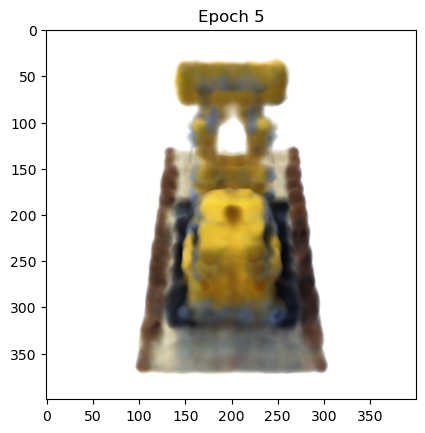

 60%|██████    | 6/10 [07:03<04:38, 69.50s/it]

Loss: 188.6511
Loss: 187.3912
Loss: 180.2996
Loss: 186.6638
Loss: 181.2296
Loss: 178.1407
Loss: 176.4847
Loss: 179.8009
Loss: 178.4415
Loss: 183.3456
Loss: 192.1961
Loss: 179.0296
Loss: 180.3158
Loss: 187.0526
Loss: 185.5652
Loss: 188.6538
Loss: 178.2569
Loss: 186.2070
Loss: 175.3560
Loss: 181.9880
Loss: 196.5645
Loss: 180.2618
Loss: 184.4497
Loss: 181.3781
Loss: 190.3651
Loss: 190.9760
Loss: 184.6255
Loss: 189.7320
Loss: 172.9646
Loss: 159.9783
Loss: 181.8863
Loss: 189.2753
Loss: 182.6206
Loss: 166.5115
Loss: 181.9572
Loss: 184.4021
Loss: 191.4791
Loss: 187.5118
Loss: 186.2989
Loss: 188.7200
Loss: 198.2007
Loss: 178.4765
Loss: 186.1091
Loss: 190.4573
Loss: 186.2500
Loss: 189.9524
Loss: 193.3610
Loss: 190.1669
Loss: 186.7964
Loss: 187.9979
Loss: 189.7693
Loss: 185.2987
Loss: 180.8266
Loss: 189.3262
Loss: 189.7401
Loss: 185.0216
Loss: 190.7029
Loss: 184.4055
Loss: 180.4123
Loss: 182.1738
Loss: 183.5953
Loss: 182.5655
Loss: 187.9193
Loss: 182.8165
Loss: 186.8882
Loss: 185.1843
Loss: 176.

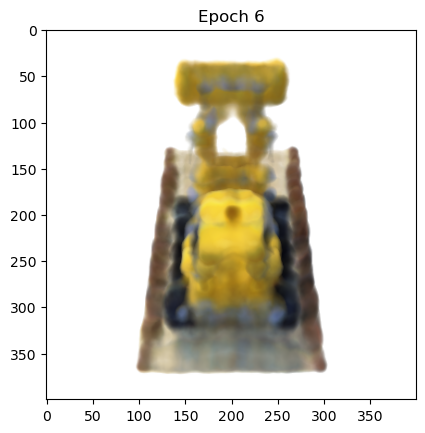

 70%|███████   | 7/10 [08:13<03:28, 69.65s/it]

Loss: 189.1316
Loss: 184.8804
Loss: 192.7731
Loss: 189.4173
Loss: 192.2525
Loss: 172.3643
Loss: 173.9863
Loss: 190.2649
Loss: 179.5444
Loss: 183.2695
Loss: 176.9427
Loss: 187.9153
Loss: 189.0385
Loss: 185.1094
Loss: 189.7173
Loss: 184.4321
Loss: 188.0267
Loss: 182.6255
Loss: 173.9419
Loss: 172.7823
Loss: 168.0414
Loss: 192.1999
Loss: 169.7561
Loss: 180.4023
Loss: 173.5785
Loss: 182.4392
Loss: 181.1208
Loss: 170.5831
Loss: 184.5987
Loss: 187.0166
Loss: 184.9700
Loss: 179.7271
Loss: 184.0970
Loss: 177.4237
Loss: 178.6608
Loss: 164.6533
Loss: 193.1446
Loss: 170.1066
Loss: 177.3042
Loss: 187.2685
Loss: 177.2872
Loss: 186.5314
Loss: 172.5803
Loss: 182.9142
Loss: 179.3509
Loss: 174.6667
Loss: 185.2239
Loss: 177.5099
Loss: 195.5043
Loss: 175.2860
Loss: 183.4196
Loss: 193.0854
Loss: 177.7542
Loss: 178.3474
Loss: 165.9360
Loss: 178.7675
Loss: 191.4478
Loss: 201.6430
Loss: 181.8093
Loss: 174.7293
Loss: 186.9415
Loss: 185.7813
Loss: 177.6947
Loss: 180.0774
Loss: 179.1127
Loss: 190.3772
Loss: 184.

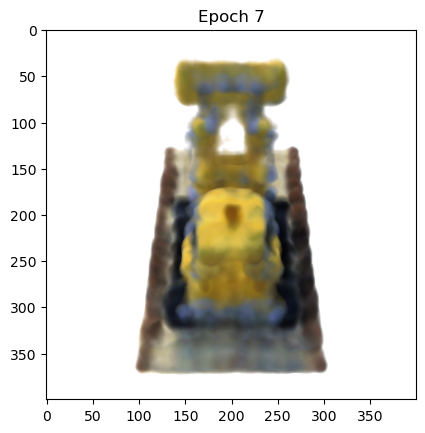

 80%|████████  | 8/10 [09:25<02:20, 70.34s/it]

Loss: 190.7156
Loss: 196.6781
Loss: 176.9121
Loss: 189.7769
Loss: 168.6348
Loss: 182.6390
Loss: 170.0429
Loss: 184.8133
Loss: 188.0988
Loss: 170.9978
Loss: 186.3366
Loss: 191.9428
Loss: 183.3608
Loss: 172.2507
Loss: 171.3611
Loss: 173.2467
Loss: 169.8837
Loss: 171.8179
Loss: 176.0984
Loss: 185.3437
Loss: 183.1742
Loss: 165.4608
Loss: 176.8246
Loss: 179.9384
Loss: 177.8930
Loss: 173.1214
Loss: 173.2262
Loss: 190.7155
Loss: 181.8130
Loss: 185.3638
Loss: 176.6421
Loss: 166.8846
Loss: 177.8582
Loss: 181.2714
Loss: 176.5397
Loss: 168.9410
Loss: 175.1064
Loss: 170.4814
Loss: 168.6186
Loss: 172.0446
Loss: 175.5206
Loss: 167.1989
Loss: 176.0420
Loss: 175.7984
Loss: 161.8369
Loss: 188.7973
Loss: 165.4054
Loss: 163.9874
Loss: 170.6849
Loss: 169.0334
Loss: 170.9864
Loss: 181.6271
Loss: 172.2896
Loss: 172.5378
Loss: 164.7538
Loss: 177.2640
Loss: 172.1909
Loss: 153.2462
Loss: 182.8102
Loss: 179.2966
Loss: 161.7667
Loss: 179.4104
Loss: 181.2482
Loss: 172.7714
Loss: 182.2960
Loss: 172.8928
Loss: 169.

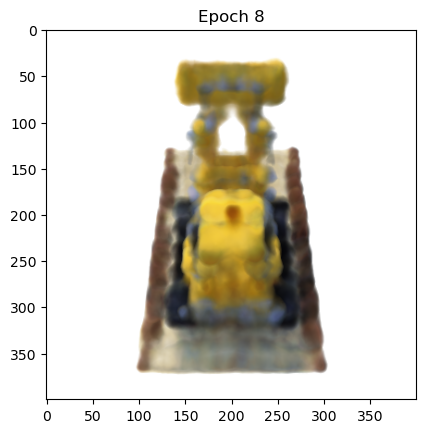

 90%|█████████ | 9/10 [10:34<01:09, 69.96s/it]

Loss: 185.0339
Loss: 160.3557
Loss: 169.8347
Loss: 162.8951
Loss: 169.9097
Loss: 163.6670
Loss: 172.8481
Loss: 167.3398
Loss: 160.7853
Loss: 168.8293
Loss: 176.6526
Loss: 173.7023
Loss: 175.3076
Loss: 171.0865
Loss: 170.7976
Loss: 169.7700
Loss: 179.3957
Loss: 163.6025
Loss: 167.0943
Loss: 171.7476
Loss: 177.0112
Loss: 174.5975
Loss: 155.1881
Loss: 179.1045
Loss: 163.6901
Loss: 174.9964
Loss: 170.1469
Loss: 173.2811
Loss: 169.0527
Loss: 173.9685
Loss: 162.1206
Loss: 173.7169
Loss: 169.6174
Loss: 172.6321
Loss: 170.9801
Loss: 175.5771
Loss: 161.9592
Loss: 184.7665
Loss: 161.7443
Loss: 163.2203
Loss: 162.1148
Loss: 161.8252
Loss: 174.1170
Loss: 171.3524
Loss: 182.9956
Loss: 169.7942
Loss: 171.4686
Loss: 160.9175
Loss: 169.5746
Loss: 163.8660
Loss: 178.2681
Loss: 167.2039
Loss: 170.8055
Loss: 173.6593
Loss: 188.3629
Loss: 168.5526
Loss: 167.8917
Loss: 157.5529
Loss: 174.2737
Loss: 181.7172
Loss: 184.6559
Loss: 172.1138
Loss: 170.5714
Loss: 180.4026
Loss: 176.0954
Loss: 173.4996
Loss: 175.

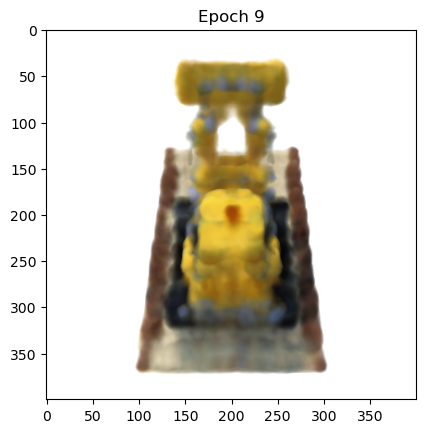

100%|██████████| 10/10 [11:43<00:00, 70.40s/it]


In [10]:
device = 'mps'
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
downscaled_data = training_dataset.reshape([100, 400, 400, 9])[..., ::4, ::4, 0:9].flatten(end_dim=-2)
testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))
model = NeRFModel(hidden_dim=256).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[2, 4, 8], gamma=0.5)
data_loader = DataLoader(downscaled_data, batch_size=8*1024, shuffle=True)
print(f" ")
loss, test_images = train(model, model_optimizer, scheduler, data_loader, testing_dataset, nb_epochs=10, device=device, hn=2, hf=6, nb_bins=32, H=400, W=400)

In [26]:
def plot_images(images, grid = (2,5), titles=None, figsize=(20, 8)):
    fig, axes = plt.subplots(grid[0], grid[1], figsize=figsize)
    
    for idx, (ax, img) in enumerate(zip(axes.flat, images)):
        ax.imshow(img)
        ax.axis('off')
        
        if titles is not None and idx < len(titles):
            ax.set_title(titles[idx])
    
    plt.tight_layout()
    plt.show()

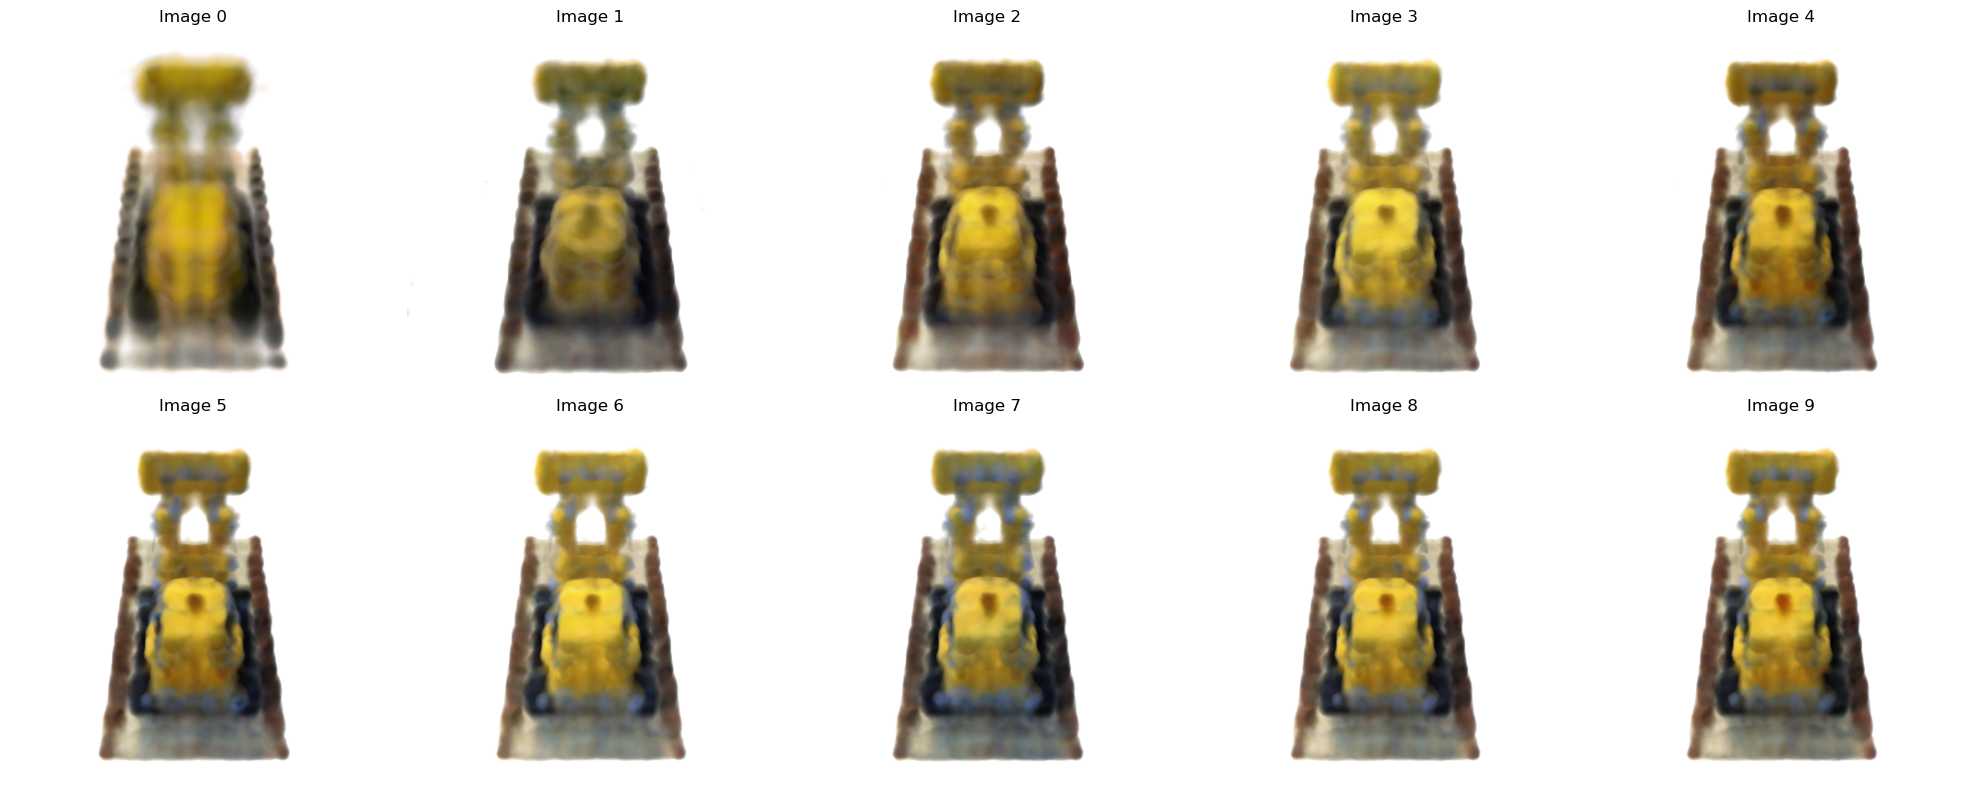

In [11]:
titles = [f"Image {i}" for i in range(10)]  
plot_images(test_images, titles)

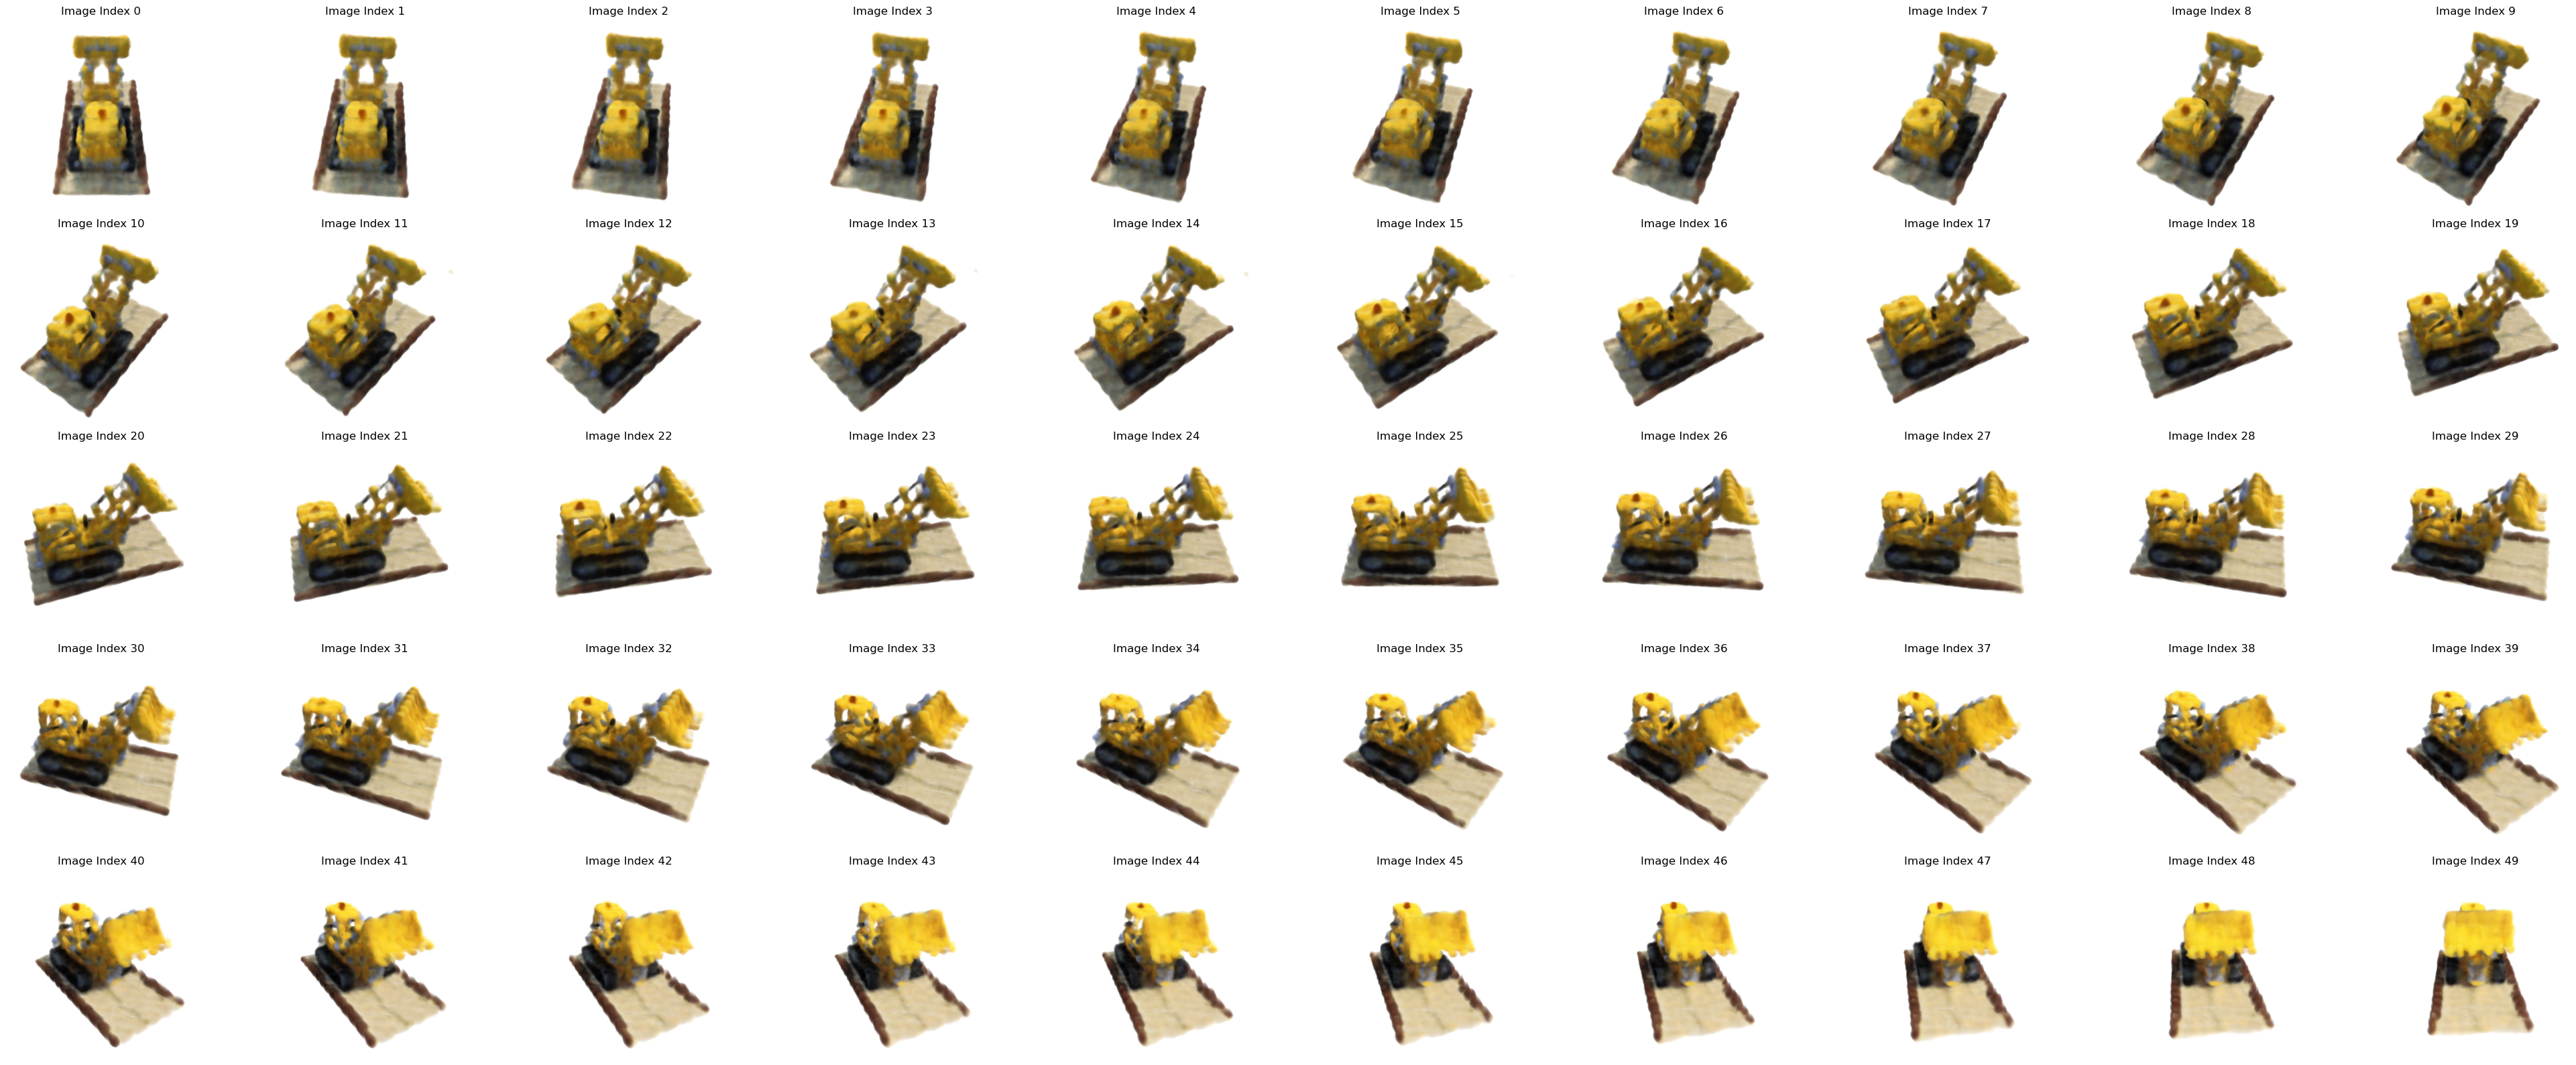

In [ ]:
images = []
for i in range(0, 50):
    img = test(model, testing_dataset, img_index=i, hn=2, hf=6, nb_bins=32, device=device, H=400, W=400)
    images.append(img)
titles = [f"Image Index {i}" for i in range(50)] 
plot_images(images,(5, 10), titles, figsize=(40, 16))